In [1]:
# k crossover d，close > ema 8, ema 8 > ema 14, ema 14 > 50, take profit 2 atr, stop loss 3 atr
# ! conda install -c conda-forge ta --yes

In [2]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '15m'

# start epoch till now
start_time = 1672556317000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [4]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    rawdf = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        rawdf = pd.concat([rawdf, out], axis = 0)
    
    rawdf = rawdf[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    rawdf = rawdf.astype(convert_dict)
    
    rawdf['Close_Time'] = pd.to_datetime(rawdf['Close_Time'], unit = 'ms')
    rawdf['Close_Time'] = rawdf['Close_Time'] + pd.Timedelta(hours=timezone)
    rawdf['Close_Time'] = rawdf['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    rawdf = rawdf.reset_index(drop=True)
    
    return rawdf

In [5]:
rawdf = get_historical(symbol, interval, start_time, end_time, step)
print(rawdf)

               Close_Time     Open    Close     High      Low     Volume
0     2023-01-01 15:14:59  1194.81  1194.37  1195.18  1193.63  1675.1834
1     2023-01-01 15:29:59  1194.36  1194.60  1194.61  1193.04  1522.0955
2     2023-01-01 15:44:59  1194.61  1195.16  1195.17  1193.80   910.7322
3     2023-01-01 15:59:59  1195.16  1195.06  1195.75  1194.61  1718.7587
4     2023-01-01 16:14:59  1195.07  1194.51  1195.90  1194.50  1266.4382
...                   ...      ...      ...      ...      ...        ...
8032  2023-03-26 08:29:59  1741.88  1740.98  1742.66  1739.31  1547.5482
8033  2023-03-26 08:44:59  1740.99  1749.49  1752.00  1740.52  3854.0625
8034  2023-03-26 08:59:59  1749.49  1750.58  1756.61  1749.49  5119.9832
8035  2023-03-26 09:14:59  1750.58  1748.59  1752.07  1748.39  2076.9010
8036  2023-03-26 09:29:59  1748.59  1748.90  1750.23  1747.94   673.0199

[8037 rows x 6 columns]


In [6]:
df = rawdf.copy()

In [7]:
def indicators(df):

# ema
    for i in (8, 14, 50, 200):
        df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# atr
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)

# kd
    kd_int = 14
    d_int = 3
   
    kddf = pd.DataFrame()
    kddf[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kddf[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slowk'] = (df['Close'] - kddf[str(kd_int) + '-Low'])*100/(kddf[str(kd_int) + '-High'] - kddf[str(kd_int) + '-Low'])
    df['slowd'] = df['slowk'].rolling(d_int).mean()
    
    return df

def checkcross(df):
    series = df['slowk'] > df['slowd']
    return series.diff() & series

In [8]:
indicators(df)
df['kd_cross'] = checkcross(df)
print(df)

               Close_Time     Open    Close     High      Low     Volume  \
0     2023-01-01 15:14:59  1194.81  1194.37  1195.18  1193.63  1675.1834   
1     2023-01-01 15:29:59  1194.36  1194.60  1194.61  1193.04  1522.0955   
2     2023-01-01 15:44:59  1194.61  1195.16  1195.17  1193.80   910.7322   
3     2023-01-01 15:59:59  1195.16  1195.06  1195.75  1194.61  1718.7587   
4     2023-01-01 16:14:59  1195.07  1194.51  1195.90  1194.50  1266.4382   
...                   ...      ...      ...      ...      ...        ...   
8032  2023-03-26 08:29:59  1741.88  1740.98  1742.66  1739.31  1547.5482   
8033  2023-03-26 08:44:59  1740.99  1749.49  1752.00  1740.52  3854.0625   
8034  2023-03-26 08:59:59  1749.49  1750.58  1756.61  1749.49  5119.9832   
8035  2023-03-26 09:14:59  1750.58  1748.59  1752.07  1748.39  2076.9010   
8036  2023-03-26 09:29:59  1748.59  1748.90  1750.23  1747.94   673.0199   

            ema_8       ema_14       ema_50      ema_200       atr      slowk  \
0     

In [9]:
def conditions(df):
    # k crossover d，close > ema 8, ema 8 > ema 14, ema 14 > 50, take profit 2 atr, stop loss 3 atr

    for index, row in df.iterrows():
        # c1
        df['c1'] = df['kd_cross']
        # c2
        df['c2'] = df['Close'] >= df['ema_8']
        # c3
        df['c3'] = df['ema_8'] >= df['ema_14']
        # c4
        df['c4'] = df['ema_14'] >= df['ema_50']
            

    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3 & df.c4, 'signal'] = True


    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [10]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,ema_8,ema_14,ema_50,ema_200,atr,slowk,slowd,kd_cross,c1,c2,c3,c4,signal,openbuy
0,2023-01-01 15:14:59,1194.81,1194.37,1195.18,1193.63,1675.1834,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False,False,False,False
1,2023-01-01 15:29:59,1194.36,1194.60,1194.61,1193.04,1522.0955,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False,False,False,False
2,2023-01-01 15:44:59,1194.61,1195.16,1195.17,1193.80,910.7322,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False,False,False,False
3,2023-01-01 15:59:59,1195.16,1195.06,1195.75,1194.61,1718.7587,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False,False,False,False
4,2023-01-01 16:14:59,1195.07,1194.51,1195.90,1194.50,1266.4382,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8032,2023-03-26 08:29:59,1741.88,1740.98,1742.66,1739.31,1547.5482,1739.960702,1738.634407,1740.921245,1756.722136,5.397544,71.444322,79.221777,False,False,True,True,False,False,False
8033,2023-03-26 08:44:59,1740.99,1749.49,1752.00,1740.52,3854.0625,1742.078324,1740.081819,1741.257275,1756.650175,5.832005,89.532944,79.127666,True,True,True,True,False,False,False
8034,2023-03-26 08:59:59,1749.49,1750.58,1756.61,1749.49,5119.9832,1743.967585,1741.481577,1741.622872,1756.589775,5.924005,78.908709,79.961992,False,False,True,True,False,False,False
8035,2023-03-26 09:14:59,1750.58,1748.59,1752.07,1748.39,2076.9010,1744.994789,1742.429366,1741.896092,1756.510175,5.763719,71.948234,80.129962,False,False,True,True,True,False,False


In [11]:
buydf = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan
close_val = buydf['Close']
atr_val = buydf['atr']

for index, row in buydf.iterrows():

    if index == 0:
        continue
        
        # set entry price
        # set stop loss
        # 進場
    
    elif buydf.at[index, 'openbuy'] == True:
   
        buydf.at[index, 'entry_p'] = close_val.shift(1).at[index]
        buydf.at[index, 'stop_loss'] = close_val.shift(1).at[index] - 3 * atr_val.shift(1).at[index]
        buydf.at[index, 'take_profit'] = close_val.shift(1).at[index] + 3.5 * atr_val.shift(1).at[index]
        buydf.at[index, 'position'] = 'Buy'
        buydf.at[index, 'status'] = 'Pending'
        in_position = True
        stop_loss = buydf.at[index, 'stop_loss']
    
for index, row in buydf.iterrows():
    # Check if the jth row's status is 'Pending'
    if df.loc[index, 'status'] == 'Pending':
        for j in range(index, len(buydf)):
            if df.loc[j, 'High'] >= df.loc[index, 'take_profit']:
                # If the price is higher, calculate the profit
                profit = df.loc[index, 'take_profit'] - df.loc[index, 'entry_p']
                # Set the 'Status' column in the jth row to 'Sold'
                df.loc[index, 'status'] = 'Sell'
                # Set the 'take_profit' column in the jth row to the calculated profit
                df.loc[index, 'profit'] = profit
                break

            if df.loc[j, 'Close'] <= df.loc[index, 'stop_loss']:
                profit = df.loc[index, 'stop_loss'] - df.loc[index, 'entry_p']
                df.loc[index, 'status'] = 'Stop'
                df.loc[index, 'profit'] = profit
                break
        
for index, row in buydf.iterrows():

    if df.loc[index, 'status'] == 'Pending':
        df.loc[index, 'profit'] = 0

    
buydf.to_csv('buydf.csv')

raw_entry_df = buydf.copy()


# 過濾有訊號或事件發生的Ｋ線
buydf = buydf[(buydf['openbuy'] == True) |
              (buydf['signal'] == True) | 
              (buydf['position'] == 'Buy') |
              (buydf['position'] == 'Sell') |
              (buydf['position'] == 'Stop')]


print(buydf)


               Close_Time     Open    Close     High      Low     Volume  \
53    2023-01-02 04:29:59  1202.19  1202.98  1204.67  1202.19  1842.7594   
54    2023-01-02 04:44:59  1202.98  1202.21  1203.59  1202.20   821.1889   
57    2023-01-02 05:29:59  1200.96  1202.12  1202.13  1200.95   650.5108   
58    2023-01-02 05:44:59  1202.12  1202.55  1202.73  1201.83   783.5873   
64    2023-01-02 07:14:59  1201.04  1202.15  1202.49  1200.29  1864.0278   
...                   ...      ...      ...      ...      ...        ...   
7853  2023-03-24 10:29:59  1817.70  1816.92  1817.70  1816.01  2457.8651   
7874  2023-03-24 15:44:59  1811.91  1812.83  1813.22  1811.13  3420.8558   
7875  2023-03-24 15:59:59  1812.83  1815.18  1817.48  1812.83  5149.9898   
8000  2023-03-26 00:29:59  1754.78  1756.39  1756.45  1752.72  2255.7448   
8001  2023-03-26 00:44:59  1756.40  1755.69  1757.76  1754.09  4215.1254   

            ema_8       ema_14       ema_50      ema_200  ...    c3    c4  \
53    1202

In [12]:
# 部位回測

posdf = buydf.copy()
posdf = posdf.reset_index(drop = True)
posdf = posdf[(posdf['position'] == 'Buy')]


col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'atr', 'position', 'entry_p', 'stop_loss', 'take_profit', 'status', 'profit']
pos = posdf[col]
pos = pos.reset_index(drop = True)

        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
entry_size = 1
fee = 0.03 / 100
entry_amt = pos.entry_p.sum() * entry_size
SL_amt = pos.loc[pos.status == 'Stop', 'stop_loss'].sum() * entry_size
TP_amt = pos.loc[pos.status == 'Sell', 'take_profit'].sum() * entry_size
ttl_fee = (entry_amt + SL_amt + TP_amt) * fee

# 損益
leverage = 10
ttl_profit = pos.profit.sum() * entry_size - ttl_fee

wins = pos['status'].str.count('Sell').sum()
loses = pos['status'].str.count('Stop').sum()
win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)

result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)



              Close_Time     Open    Close     High      Low       atr  \
0    2023-01-02 04:44:59  1202.98  1202.21  1203.59  1202.20  1.478002   
1    2023-01-02 05:44:59  1202.12  1202.55  1202.73  1201.83  1.370776   
2    2023-01-02 07:29:59  1202.14  1200.17  1202.37  1200.16  1.330668   
3    2023-01-02 12:59:59  1200.73  1201.85  1201.86  1200.57  1.666354   
4    2023-01-02 13:44:59  1201.91  1202.55  1202.55  1201.14  1.624916   
..                   ...      ...      ...      ...      ...       ...   
530  2023-03-24 08:44:59  1815.53  1816.24  1818.08  1814.52  7.513902   
531  2023-03-24 09:44:59  1814.14  1817.25  1818.33  1812.60  7.005237   
532  2023-03-24 10:29:59  1817.70  1816.92  1817.70  1816.01  6.134707   
533  2023-03-24 15:59:59  1812.83  1815.18  1817.48  1812.83  4.185665   
534  2023-03-26 00:44:59  1756.40  1755.69  1757.76  1754.09  5.491511   

    position  entry_p    stop_loss  take_profit status     profit  
0        Buy  1202.98  1198.525686  1208.17

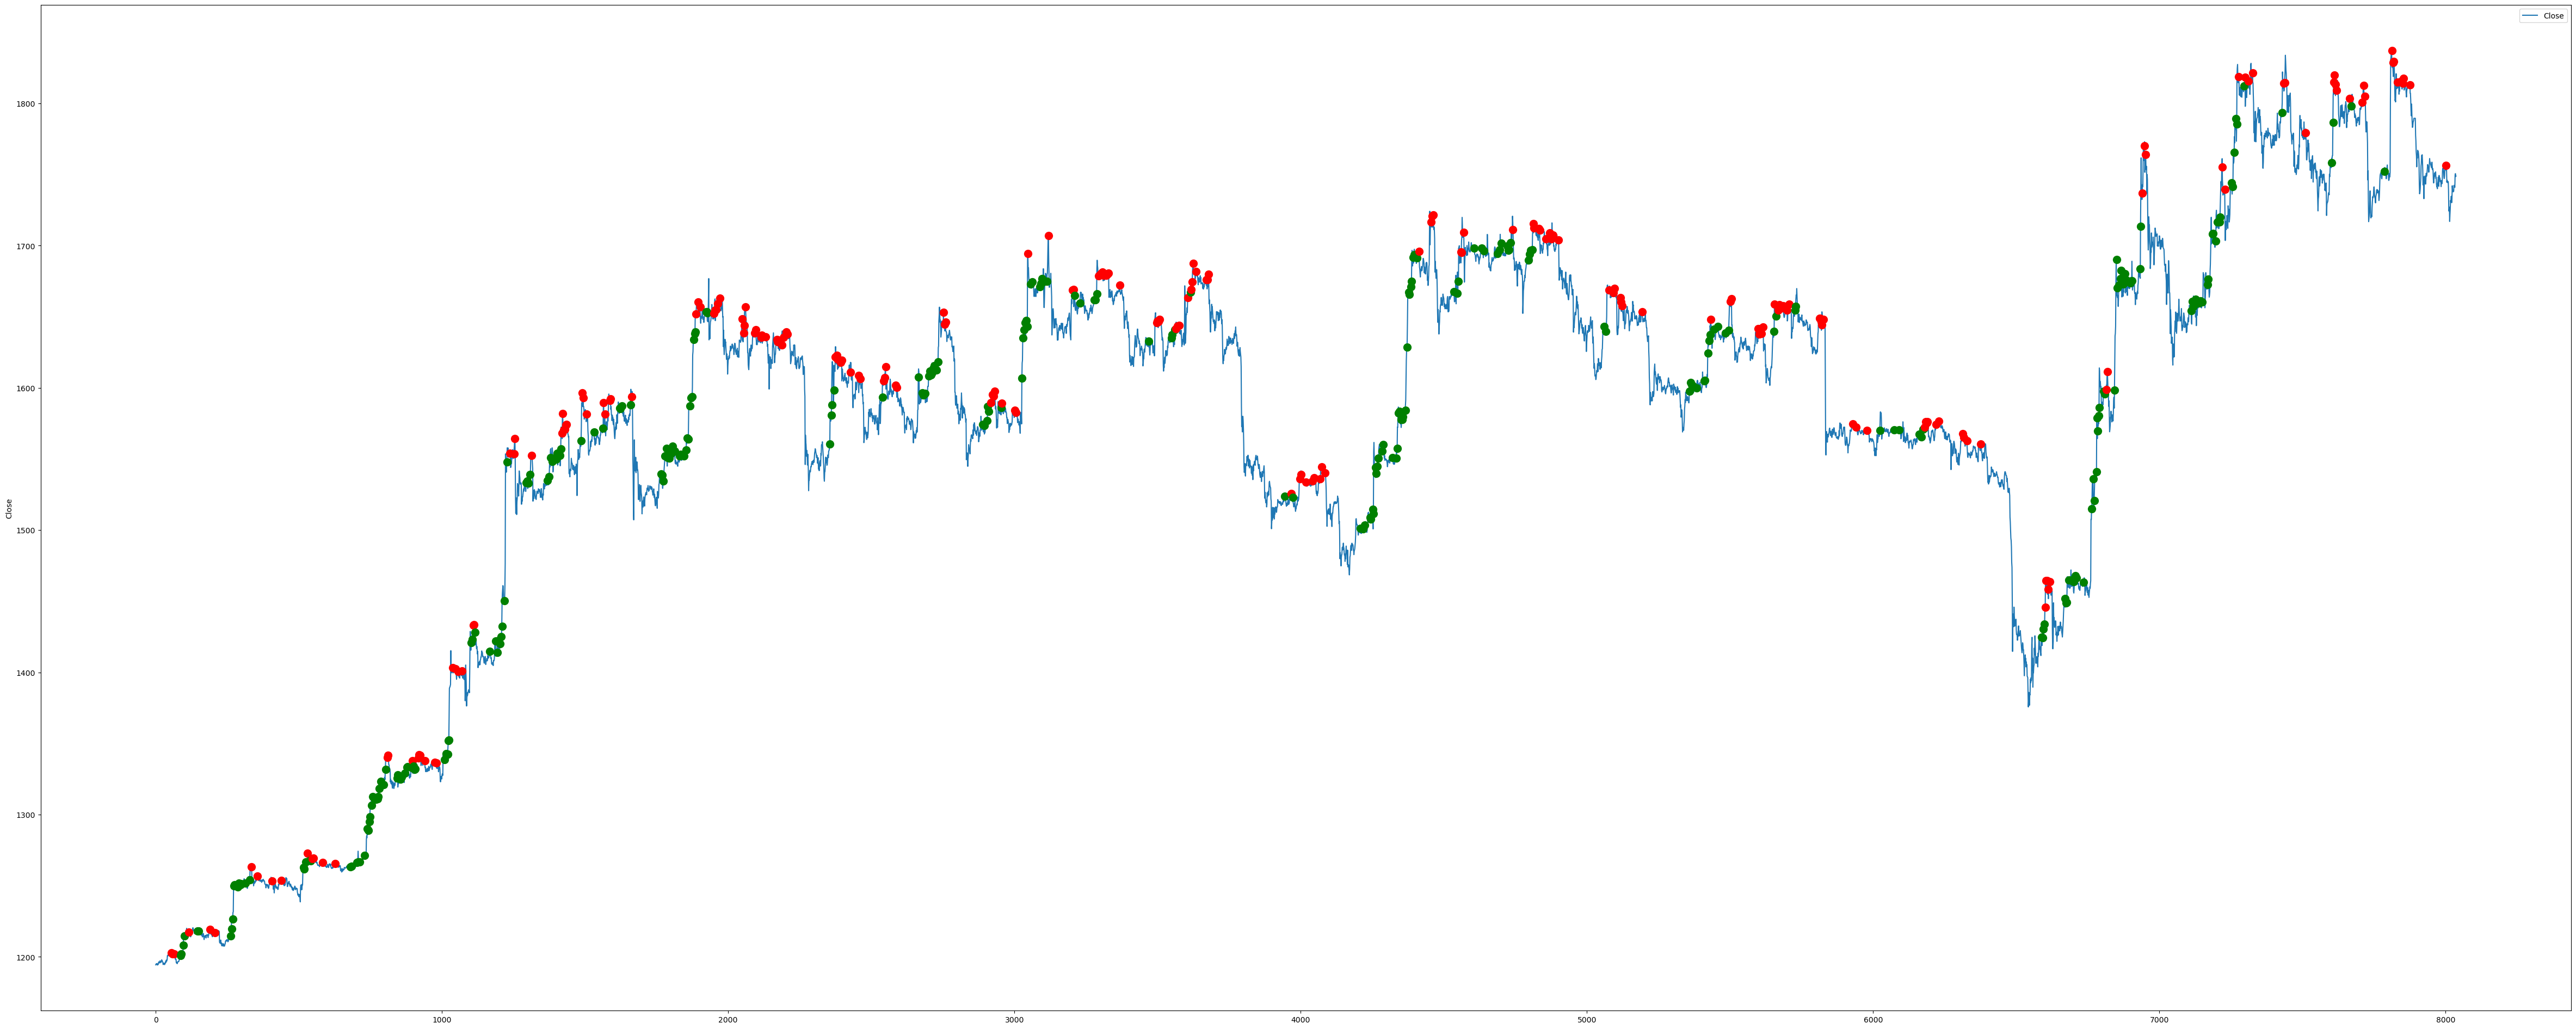

In [13]:
plt_df = raw_entry_df.copy()

plt.figure(figsize=(60, 24))
plt.ylabel('Close')
plt.plot(plt_df.Close, label = 'Close')
for i in range(len(plt_df)):
    if plt_df.status[i] == 'Sell':
        plt.plot(i, plt_df.entry_p[i], 'go', label='_', markersize=10)
    elif plt_df.status[i] == 'Stop':
        plt.plot(i, plt_df.entry_p[i], 'ro', label='_', markersize=10)
# plt.plot(plt_df.ema_8, label='ema_8', c='g', lw=0.5)
# plt.plot(plt_df.ema_14, label='ema_14', c='r', lw=0.5)
# plt.plot(plt_df.ema_50, label='ema_50', c='b', lw=0.5)
# plt.plot(plt_df.ema_200, label='ema_200', c='y', lw=4)
plt.legend()
plt.show()